In [19]:
import copy

import numpy as np
import torch.nn as nn
import torchvision
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM

import compression.quantization as module_quantize
import data as module_data
import models as module_arch
from parse_config import ConfigParser
from trainer.callbacks import IterativePruning, Quantization
from trainer.lit_model import LitModel
from utils import plot_sparsity_matrix, plot_weight_histograms, make_paths_relative_to_root, imshow

make_paths_relative_to_root()

# Introduction
This notebook shows an example of the Deep Compression process, described in the paper "Deep Compression: compressing deep neural networks with pruning, trained quantization and Huffman Coding, Song Han et al., 2016." [[1](#1)]
Here we replicate the process on MNIST dataset, using the LeNet-300-100 model [[2](#2)].

# Configuration

In [20]:
# Retrieve a pretrained model
config_dict = {'config':'configs/LeNet300/lenet-300-pretrain.json'}

config = ConfigParser.from_dict(config_dict)

data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


Print images from dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0 0 7 3


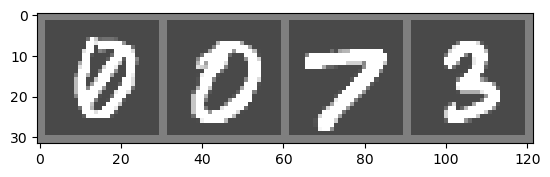

In [21]:
# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

LeNet-300-100 is a Fully-Connected neural network, presented in [[2](#2)].
It is composed by two hidden layers, with respectively 300 and 100 units.

Differently from the original implementation, we employ ReLU activation instead of tanh, and we use a softmax over the last layer logits to calculate the predictions and a negative log likelihood loss.

In [22]:
from pytorch_lightning import Trainer

# build model architecture
model = LitModel(config,config.init_obj('arch', module_arch))
print(model)

trainer = Trainer(
    accelerator="gpu",enable_checkpointing=False,logger=False,max_epochs=10
)

trainer.fit(model, data_loader, valid_data_loader)

GPU available: True (cuda), used: True


LitModel(
  (model): LeNet300(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=10, bias=True)
    (dropout): Dropout(p=0, inplace=False)
  )
)


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | LeNet300 | 266 K 
-----------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


The error rate on the validation set is 1.8%, which is slightly worse than what declared in the Deep Compression paper and in the original article of LeCun et al. , 1998.

## Pruning

We have explored two ways of pruning:
- pruning a certain percentage of weights, ranked by their weight magnitude.
- pruning all the weights under a threshold, given by the standard deviation of weight magnitude, multiplied by a quality constant $s$.

$$ \text{threshold} = \sigma * s $$

The second one is the method used in the original paper, however the first one offer a more straightforward control over the percentage of pruned weights. We can find an equivalence between the two methods by assuming that the weights are approximately normally distributed, and calculating the CDF of the weight distribution.

In [23]:
# Custom callback extending ModelPruning callback adding configuration on which epochs to prune. Executes pruning function after specified training epoch.
pruning_callback = IterativePruning(
    pruning_schedule={"epochs":[0]},
    pruning_fn="l1_unstructured",
    parameter_names=["weight"],
    amount=0.92,
    use_global_unstructured=True,
    make_pruning_permanent=False,
    verbose=2
)
trainer = Trainer(
    accelerator="gpu",enable_checkpointing=False,logger=False,max_epochs=10,callbacks = [pruning_callback]
)

trainer.fit(model,data_loader,valid_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | LeNet300 | 266 K 
-----------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Applied `L1Unstructured`. Pruned: 0/266610 (0.00%) -> 244904/266610 (91.86%)
Applied `L1Unstructured` to `Linear(in_features=784, out_features=300, bias=True).weight` with amount=0.92. Pruned: 0 (0.00%) -> 224308 (95.37%)
Applied `L1Unstructured` to `Linear(in_features=300, out_features=100, bias=True).weight` with amount=0.92. Pruned: 0 (0.00%) -> 20401 (68.00%)
Applied `L1Unstructured` to `Linear(in_features=100, out_features=10, bias=True).weight` with amount=0.92. Pruned: 0 (0.00%) -> 195 (19.50%)


Sparsity stats of `LitModel` - `weight`:
  Layer model.fc1: retained 10892/235200 (4.63%) 
  Layer model.fc2: retained 9599/30000 (32.00%) 
  Layer model.fc3: retained 805/1000 (80.50%) 
Total:  Pruned: 244904/266200 (92.00%)  Retained: 21296/266200 (8.00%)  Compression: 12.5 X


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Validation accuracy drops after pruning, but once the model is finetuned, we reach a slightly better accuracy than the unpruned model. This was also noted in the Deep Compression paper

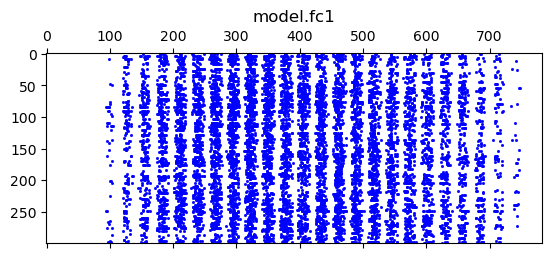

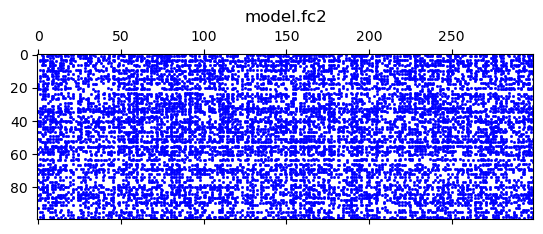

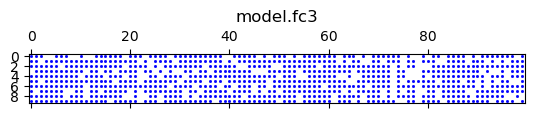

In [24]:
plot_sparsity_matrix(model)

We can see that the fc1 layer is divided in 28 vertical bands, whose width is 28, corresponding to the $28 \times 28$ input pixel.
As stated in [[2](#2)], network pruning detects visual attention regions: the colored regions, correspond to non-zero parameters, are more dense in the center of the image, since the digits are written in the center.

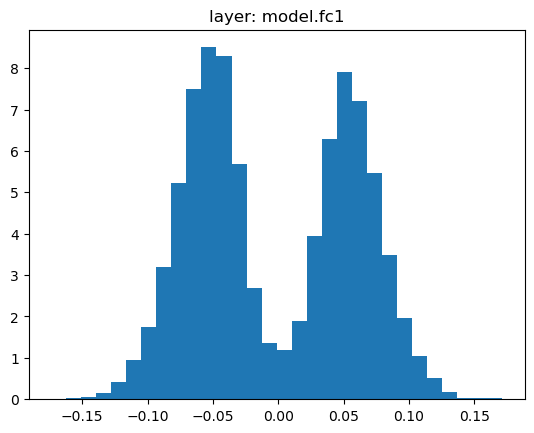

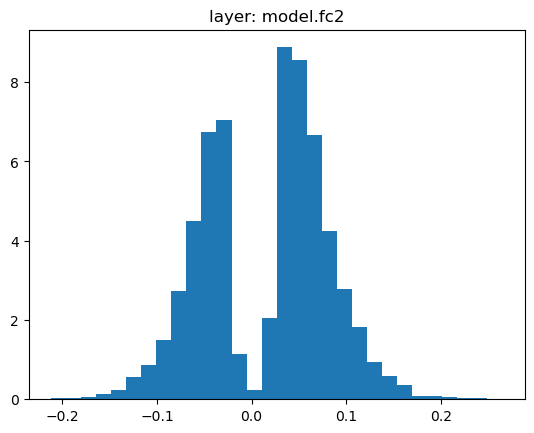

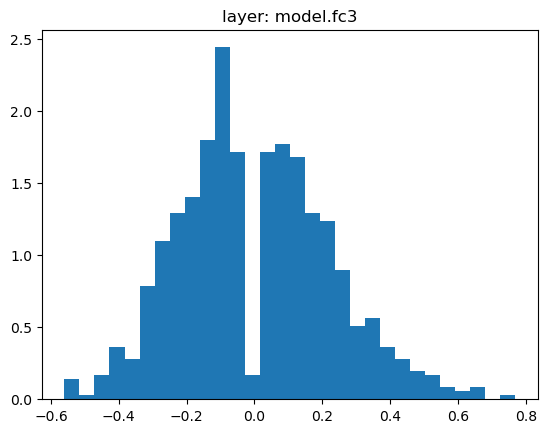

In [25]:
plot_weight_histograms(model)

Pruned weights follow a bimodal distribution

In the article, pruned weights are stored in a vector which encodes the index difference between nonzero weights to save additional space. We can see how index differences are distributed, and choose the number of bits we can use to encode the difference.

We can use only 5 bits, and if there is a difference is greater than the maximum representable number, we can store additional placeholder zeros between those weights.

Number of placeholder zeros to add: 4196


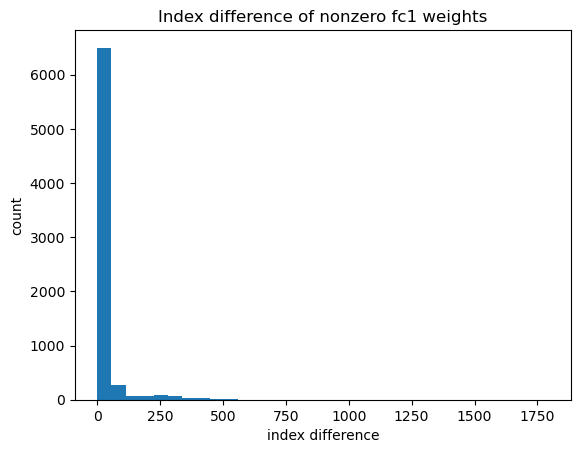

In [26]:

import matplotlib.pyplot as plt

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

# get weights from layer fc1 and calculate the start and end of contiguous zeros
tensor = model.model.fc1.weight_mask.detach().cpu().view(-1).numpy()
r = zero_runs(tensor)
# calculate difference between the indexes
diff = r[:-1,1] - r[:-1,0]
if r[0,0] != 0:
    diff = np.concatenate(([r[0,0]], diff))

placeholder_zeros = np.array(list(map(lambda i: i//32, diff[diff > 32])))
print("Number of placeholder zeros to add: {:d}".format(placeholder_zeros.sum()))

plt.hist(diff, bins=32)
plt.xlabel("index difference")
plt.ylabel("count")
plt.title("Index difference of nonzero fc1 weights")
plt.show()

## Quantization

There are two ways of doing quantization:

- Reducing the number of bits used to represent each weight
- Create a codebook of weight values using a clustering algorithm, so that each weight that falls into the cluster will have the same shared weight.

We have implemented the latter using three different quantization methods, which can be found inside `compression.quantization` module.
All the methods extend a common class `BaseQuantizationMethod` and differ by the way the centroids are computed. The module structure was largely inspired on PyTorch's torch.nn.utils.prune module, using a similar reparameterization logic of the weight parameter.

Let's show how the centroids are calculated for the weights of `fc1` layer, for simplicity let's assume to quantize the layer weights in only 3 bits (using 8 weights)

In [27]:
# Number of centroids = 2 ** #bits used to index
pts = 2 ** 3
mat = model.model.fc1.weight.detach().cpu().view(-1)
# ignore zeros from masked neurons
mat = mat[mat!=0]

### Random (Forgy) Initialization

Randomly chooses `pts` observations from the data set and uses these as the initial centroids. Since the pruned weights form a bimodal distribution, the centroids tend to concentrate around the two peaks.

In [28]:
space_f = np.random.choice(mat, size=pts, replace=False)

### Density-based Initialization

Linearly spaces the CDF in the y-axis, then finds the horizontal intersection with the CDF, and the vertical intersection on the x-axis, which becomes a centroid. Weights are concentrated around the two peaks, but more scattered than the Forgy method.

In [29]:
x, cdf_counts = np.unique(mat, return_counts=True)
y = np.cumsum(cdf_counts) / np.sum(cdf_counts)

eps = 1e-2

space_y = np.linspace(y.min() + eps, y.max() - eps, pts)

idxs = []
# TODO find numpy operator to eliminate for
for i in space_y:
    idx = np.argwhere(np.diff(np.sign(y - i)))[0]
    idxs.append(idx)

idxs = np.stack(idxs)
space_d = x[idxs]

### Linear Initialization
Linearly spaces the centroids between the [min, max] of the original weights. This initialization method is invariant to the distribution of the weights and more scattered compared with the other two methods.

In [30]:
min_ = mat.min()
max_ = mat.max()
space_l = np.linspace(min_, max_, num=pts)

We can visualize the centroids computed by these three methods and see how they are distributed with respect to the model PDF and CDF

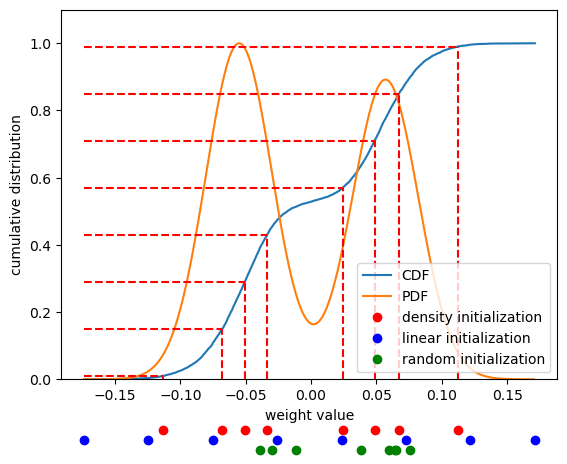

In [31]:
# credits https://stackoverflow.com/questions/55187037/how-can-i-do-a-histogram-with-1d-gaussian-mixture-with-sklearn
def normalize(x):
        return (x - x.min(0)) / x.ptp(0)

gmm = GMM(n_components=2, max_iter= 1000, random_state=0, covariance_type='full')
out = gmm.fit(x.reshape(-1,1))

mean = out.means_
covs  = out.covariances_
weights = out.weights_

x_ = np.arange(min_, max_, 1e-3)
y_gmm0 = norm.pdf(x_, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
y_gmm1 = norm.pdf(x_, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

fig, ax = plt.subplots()
ax.plot(x, y, label= 'CDF')
ax.plot(x_,normalize(y_gmm0+y_gmm1), label='PDF')

ax.set_ylabel('cumulative distribution')
ax.set_xlabel('weight value')
ax.set_ylim(0,1.1)

ax.plot(space_d,np.zeros_like(space_d) -0.15,'ro',clip_on=False,label='density initialization')
ax.plot(space_l,np.zeros_like(space_d) -0.18 ,'bo',clip_on=False,label='linear initialization')
ax.plot(space_f,np.zeros_like(space_d) -0.21,'go',clip_on=False,label='random initialization')

for idx in idxs:
    ax.hlines(y[idx], x.min(), x[idx], linestyles='--',colors='r')
    ax.vlines(x[idx], y.min(), y[idx], linestyles='--',colors='r')

ax.grid(False)
_ = ax.legend()

Let's quantize a very simple layer with 16 weights into 4 centroids and visualize the result

C:\Users\Dario\mambaforge\envs\pytorch-lightning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'After quantization')

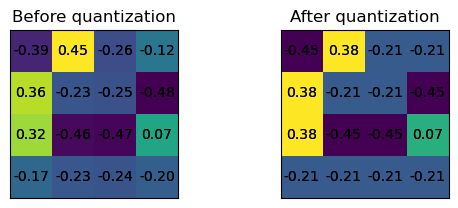

In [32]:
from compression.quantization import linear_quantization

def plot_matrix(matrix,ax):
    ax.imshow(matrix)
    ax.set_xticks([])
    ax.set_yticks([])
    for (j,i),label in np.ndenumerate(matrix):
        ax.text(i,j,f"{label:.2f}",ha='center',va='center')
        ax.text(i,j,f"{label:.2f}",ha='center',va='center')

fig = plt.figure()

layer = nn.Linear(4,4)

w = layer.weight.detach().cpu().numpy()

ax = fig.add_subplot(221)
plot_matrix(w, ax)
ax.set_title("Before quantization")

layer = linear_quantization(layer,bits=2,name="weight")
w = layer.weight.detach().cpu().numpy()

ax = fig.add_subplot(222)
plot_matrix(w, ax)
ax.set_title("After quantization")

In [33]:
quantization_callback = Quantization(
    epoch=0,
    quantization_fn="linear_quantization",
    parameter_names=["weight"],
    bits=2,
    verbose=2
)

trainer = Trainer(
    accelerator="gpu",enable_checkpointing=False,logger=False,max_epochs=10,callbacks = [quantization_callback]
)
trainer.fit(model,data_loader,valid_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | LeNet300 | 266 K 
-----------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Compression stats of `LitModel` - `weight`:
  Layer model.fc1: compression rate 0.87% (114.9X) 
  Layer model.fc2: compression rate 6.01% (16.6X) 
  Layer model.fc3: compression rate 15.49% (6.5X) 
Total compression rate: 1.50% (66.5X) 


C:\Users\Dario\mambaforge\envs\pytorch-lightning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
import matplotlib

fig, (ax0,ax1) = plt.subplots(2,sharex=False,sharey=False)

weights = model.model.fc3.weight.detach().cpu()

a = np.ma.masked_where(weights ==0, weights)

cmap = matplotlib.cm.get_cmap("jet").copy()
cmap.set_bad(color='white')

plt1 = ax0.imshow(a,interpolation=None,cmap=cmap)
fig.colorbar(plt1,ax=ax0)

x, cdf_counts = np.unique(weights[weights!=0].view(-1), return_counts=True)
print("weights: {} - counts: {}".format( x, cdf_counts))

_ = ax1.bar(x,cdf_counts)
plt.show()

## Huffman encoding

# References
<a id="1">[1]</a> Han, Song, Huizi Mao, and William J. Dally. "Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding." arXiv preprint arXiv:1510.00149 (2015).
<a id="1">[2]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[3]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).